In [4]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [5]:
import glob
import xarray as xr
import pandas as pd 

file_list = glob.glob("../../tide_models/dac/*.nc")
file_list

out = []

for file in file_list:
    da = xr.open_dataset(file).dac
    da = da.assign_coords(time=pd.to_datetime(da.date))
    out.append(da)

In [6]:
dac_da = xr.concat(out, dim="time").sortby("time")

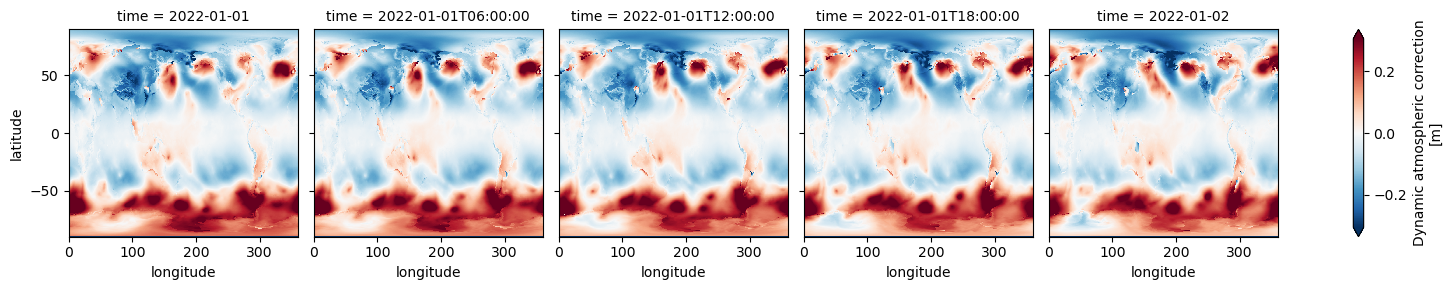

In [7]:
dac_da.isel(time=slice(0, 5)).plot(col="time", robust=True)

In [8]:
from intertidal.elevation import abslmp_gauge

In [19]:
df = pd.read_csv(
        f"/home/jovyan/tide_models/abslmp/ABSLMP_station_metadata.csv", index_col="ID CODE"
    )

In [22]:
df.iloc[0].LONGITUDE

147.0584444

Loading ABSLMP gauge IDO71015 (Milner Bay - Groote Eylandt)


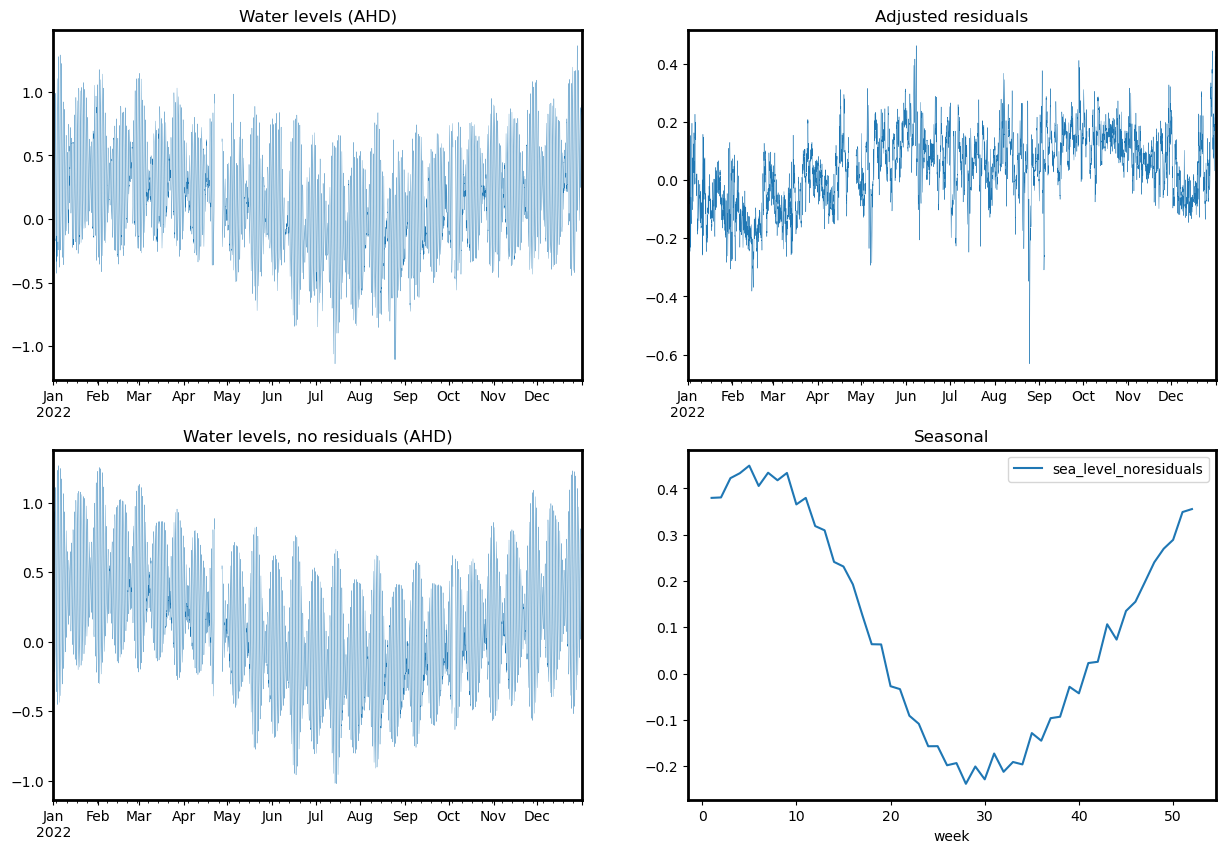

In [87]:
i = 14
lon, lat = df.iloc[i].LONGITUDE, df.iloc[i].LATITUDE

# lon, lat = 151.7589,-33.0248

abslmp_df = abslmp_gauge(coords=(lon, lat), start_year=2022, end_year=2023, data_path="/home/jovyan/tide_models/abslmp/")

In [88]:
dac_da_sampled = dac_da.interp(longitude=lon, latitude=lat)
abslmp_sampled = abslmp_df[0].to_xarray().interp(time=dac_da_sampled.time)

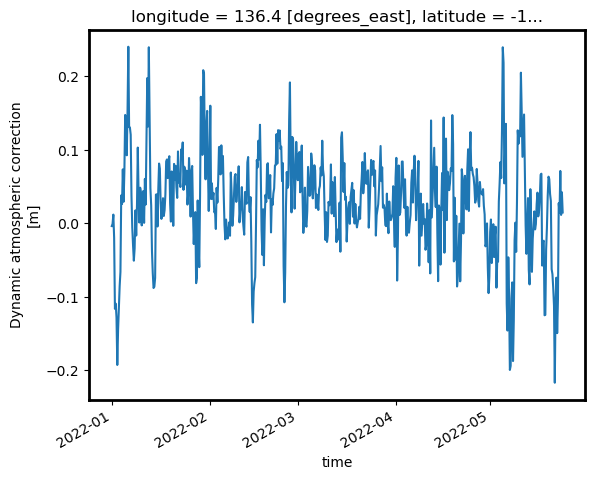

In [89]:
dac_da_sampled.plot()

In [90]:
abslmp_sampled.sea_level.std()

<xarray.DataArray 'sea_level' ()>
array(0.3543582)
Coordinates:
    longitude  float64 136.4
    latitude   float64 -13.86

In [91]:
(abslmp_sampled - dac_da_sampled).sea_level.std()

<xarray.DataArray 'sea_level' ()>
array(0.34915249)
Coordinates:
    longitude  float64 136.4
    latitude   float64 -13.86

In [92]:
import datacube

dc = datacube.Datacube()

query_params = dict(x=(lon-0.05, lon+0.05), 
                    y=(lat-0.05, lat+0.05), 
                    time=("2022-01-01", "2022-05-24"))

load_params = dict(
    # dask_chunks={}
)

ds = dc.load(product="ga_ls8c_ard_3", 
             measurements=['nbart_nir'], 
             **query_params, 
             **load_params)
ds = ds.where(ds > 0)

In [93]:
from dea_tools.coastal import tidal_tag

In [94]:
ds_out = tidal_tag(ds)


Setting tide modelling location from dataset centroid: 136.42, -13.86
Modelling tides using FES2014 tidal model


In [95]:
ds_out

<xarray.Dataset>
Dimensions:      (time: 18, y: 377, x: 378)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-10T00:58:42.779835 ... 2022-05...
  * y            (y) float64 -1.47e+06 -1.47e+06 ... -1.481e+06 -1.481e+06
  * x            (x) float64 4.776e+05 4.776e+05 ... 4.889e+05 4.889e+05
    spatial_ref  int32 3577
Data variables:
    nbart_nir    (time, y, x) float64 2.763e+03 2.782e+03 ... 2.315e+03
    tide_m       (time) float64 -0.2078 -0.2084 -0.2499 ... 0.236 0.5198 0.5209
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [96]:
dac_da_sampled = dac_da.interp(longitude=lon, latitude=lat, time=ds_out.time)
# abslmp_sampled = abslmp_df[0].to_xarray().interp(time=dac_da_sampled.time)

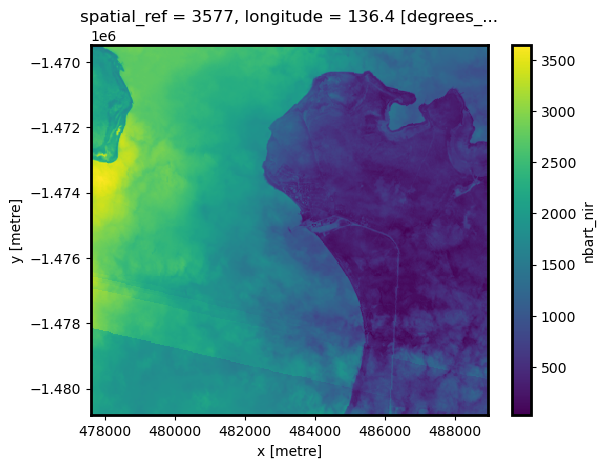

In [113]:
# dac_da_sampled
tide_filter = (ds_out.tide_m - dac_da_sampled) < 0

ds_out.sel(time=tide_filter).nbart_nir.std(dim="time").plot()

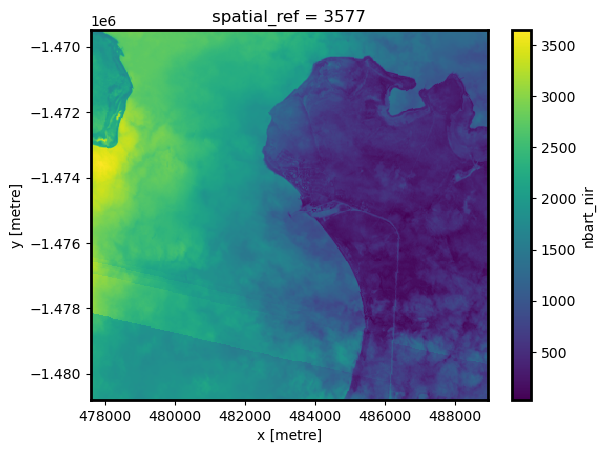

In [112]:
# dac_da_sampled
tide_filter = ds_out.tide_m < 0
ds_out.sel(time=tide_filter).nbart_nir.std(dim="time").plot()